# Code de création de data frame pour la catégorie johnson

## I) Importation des bibliothèques

C:\Users\rollan\Documents\GPU_stage\pyNanoMatBuilder-main



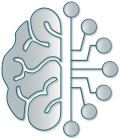

**Start at:** Monday 01 July 2024, 11:20:57  
**Hostname:** insa-11557 (Windows)

<p style="text-align: center"><img width="800px" src="./styles/svg/pyNanoMatBuilder_banner.svg" style="margin-left:auto; margin-right:auto"/></p>

<module 'pyNanoMatBuilder.utils' from 'C:\\Users\\rollan\\Documents\\GPU_stage\\pyNanoMatBuilder-main\\pyNanoMatBuilder\\utils.py'>

In [2]:
##################
# Initialization #
##################

import os
import sys

print(os.getcwd())
cwd0 = './styles/'
sys.path.append(cwd0)

import visualID as vID
from visualID import  fg, hl, bg
vID.init(cwd0)

import numpy as np
import ase
from ase.io import write
from ase.visualize import view

import pyNanoMatBuilder.utils as pNMBu
import importlib
import pandas as pd

from pyNanoMatBuilder import platonicNPs as pNP

import importlib
importlib.reload(pNP)
importlib.reload(pNMBu)

## II) Définition des fonctions nécessaires à la creation du data frame 

### Définition de la fonction clean

**Cette fonction a pour but de supprimer la ligne en trop des fichiers xyz que on va creer** 

In [3]:
def clean_xyz(filename):
    dtype = {'names': ('element', 'x', 'y', 'z'),
             'formats': ('U2', float, float, float)}    
    element,x,y,z=np.loadtxt(filename,unpack=True,skiprows=2 , usecols=(0, 1, 2, 3), dtype=dtype)
    outfile=os.path.dirname(filename)+'/'+os.path.basename(filename).split('.')[0]+'.xyz'
    nb_atoms=len(x)
    line2write=str(nb_atoms)+'\n'
    line2write+='\n'
    for i in range(nb_atoms):
        line2write+=str(element[i])+'\t %.8f'%x[i] + '\t %.8f'%y[i] + '\t %.8f'%z[i] +'\n'
    with open(outfile,'w') as file:
        file.write(line2write)
    return outfile

### Définition de la fonction de gestion des datas frame pour la catégorie des solides johnson

**Cette fonction a pour but de creer un data frame de une ligne contenant les arguments que on a donné**

In [4]:
def fonction_gestion_dataframe_shapes_johnson(element,forme,distance,size,qmin=0.01,qmax=20,qstep=0.01,biso=0.01, endroit_fich_xyz='tempxyz.xyz'):
    """
    forme (trigonal_bipyramid, pentagonal_bipyramid ) -- string
    element (ex Au )-- string
    distance = distance entre plus proche voisin -- float
    size: liste de 3 éléments, le premier est le nombre d'atome par bords, le deuxième est la taille de la partie allongée et le troisième est la marque de troncature --list integer
    qmin -- list 
    qmax -- list 
    qstep -- list 
    biso : pour simuler la vibration atomique et avoir des modèles plus réalistes -- list
    endroit_fich_xyz =  l'endroit ou on veut enregister notre fichier xyz qui sera creé pui supprimé durant l'exécution de la fonction --string
    """
    #on importe les bibliothèques utiles
    
    from pyNanoMatBuilder import crystalNPs as cyNP
    import numpy as np
    from pyNanoMatBuilder import platonicNPs as pNP
    from pyNanoMatBuilder import johnsonNPs as jNP
    from pyNanoMatBuilder import utils as pNMBu
    import importlib

    
    # Entrer l'endroit ou on veut enregister notre fichier xyz 
    fich_xyz=f"{endroit_fich_xyz}"

    
    # Création du DataFrame vide (que on viendra remplir dans la suite ) avec les colonnes spécifiées
    df = pd.DataFrame(columns=["Solid_class","Element","Shape", "Distance","Size_parameters","Eq_Radius","n_Atoms","polydispersity","qmin","qmax","qstep","b_iso","q","Intensities"])

    #Disjonction de cas selon les arguments (plus précisément la forme) que ont a rentés
    if forme != "trigonal_bipyramid" and forme != "pentagonal_bipyramid" :
        print("La forme donnée n'est pas dans la classe des solides johnson")
              

    #cas pour le trigonal_bipyramid
    if forme == "trigonal_bipyramid" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        tbp = jNP.fcctbp(f"{element}",distance,size[0],aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write(fich_xyz, tbp.NP)
        try:
            r=tbp.radiusCircumscribedSphere()
        except:
            r=0 #pas encore de fonction radius pour cette classe, donc on rentre 0 par défaut
         
        n_Atoms=tbp.nAtoms
      
    #cas pour le pentagonal_bipyramid 
    if forme == "pentagonal_bipyramid" :
        
        # #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        
        ppy1 = jNP.epbpyM(f"{element}",distance,size[0],size[1],size[2],aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write(fich_xyz, ppy1.NP)
        try:
            r=ppy1.radiusCircumscribedSphere()
        except:
            r=0 #pas encore de fonction radius pour cette classe, donc on rentre 0 par défaut
        
        n_Atoms=ppy1.nAtoms
        
      
        
       
   

    #On utilise la fonction Clean sur le fichier xyz que on vient de creer 
    xyz_file=fich_xyz
    xyz_file=clean_xyz(xyz_file)

    
    # On calcul I(q) avec la fonction debyecalculator et on rentre les tableau numpy générés dans les variable Q et I
    from debyecalculator import DebyeCalculator
    
    calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cuda',biso=0.01)
    Q, I = calc.iq(structure_source=xyz_file)

    ###### supression du fichier xyz pour garder seulement le nom
    os.remove(fich_xyz)


    # On transforme nos deux tableau numpy Q et I en tableau et on rentrer nos arguments de fonction dans des variables
    Q=Q
    Intensite=I
    Distance =distance
    Size=size
    Element= f"{element}"
    Forme=f"{forme}"
    Type_solide= "Johnson"
    Rayon=r
    Qmin=qmin
    Qmax=qmax
    Qstep=qstep
    Biso=biso
    N_Atoms=n_Atoms
    Polydispersity=0
    

    # On ajout une ligne au DataFrame (avec ce qu'on voulait dedans comme données) en utilisant loc
    df.loc[len(df)] = [Type_solide,Element, Forme, Distance, Size,Rayon,N_Atoms,Polydispersity,Qmin,Qmax,Qstep,Biso, Q,Intensite]
    
    
    return df  

### Definition de la fonction qui génère les fichier pk pour la classe johnson

**On utilise des boucles afin de parcourir toutes les formes, les éléments et le nombre de couche souhaitées.**
**On peut remarqué que à chaque élément il y a une seule distance associée, donc on ne parcours que les éléments dans la boucle**
**et on leurs associes leurs distance respective**

**On effectue ici la concaténation des data frame générés par la fonction d'haut dessus**

In [5]:
def generation_fichier_pk_johnson(forme,size,nbr_elem,List_qmax,List_qmin,List_qstep,List_biso,lieu_fich_xyz,fichier_intermediaire,fichier_sortie):
    

    # Création du data frame vide (df_concatenated) que on va remplir au fur et à mesure
    df_concatenated  = pd.DataFrame(columns=["Solid_class","Element", "Shape", "Distance","Size_parameters","Eq_Radius","n_Atoms","polydispersity","qmin","qmax","qstep","b_iso","q","Intensities"])


    # On effectue donc les boucles imbriquées
    for f in  forme :
        for s in size:
            for i in range (0,nbr_elem):
                for qmin in List_qmin:
                    for qmax in List_qmax:
                        for qstep in List_qstep:
                            for biso in List_biso:
                            
                                # Création du data frame d'une ligne avec la fonction de gestion des datas frame , et contenant les éléments de la boucle en cours
                                df_ligne = fonction_gestion_dataframe_shapes_johnson(liste_element[i],f,liste_distance[i],s,qmin,qmax,qstep,biso,lieu_fich_xyz)
                                # Concaténation du data frame globale avec la data frame d'une ligne
                                df_concatenated = pd.concat([df_concatenated , df_ligne])


        # Enregistrement forme par forme lors de grosses boucle pour garder certaines choses meme si cela crash
        df_concatenated.to_pickle(fichier_intermediaire%f)

        


    #Sauvegarder le DataFrame en CSV avec tabulation
    df_concatenated.to_pickle(fichier_sortie)


## III) Création du data frame 

**Variables à changer pour les utilisateurs**

In [12]:
# Création de la liste des couches (à changer en fonction de ce que l'on veut jusqu'a 9 apres c'est plus gros que 5nm de diamètre)
size = [[4,3,2],[5,3,2],[6,3,2],[7,3,2],[8,3,2],[9,3,2]]

# Création de la liste des formes, avec liste_de_toutes_les_formes= ["trigonal_bipyramid", "pentagonal_bipyramid"] 
forme= ["pentagonal_bipyramid"] #( à changer en fonction de ce que l'on veut (en prenant dans les elements de la liste_de_toutes_les_formes)

# Création des listes d'éléments (liste_element) et de distances (liste_distance
dtype={"names":("atom","distance"),"formats":('U2',float)} #juste pour avoir la liste des elements et des distances de dessous
liste_element,liste_distance=np.loadtxt("atom_latt2.txt",unpack=True,skiprows=1,usecols=[0,1],dtype=dtype)


# Création d'une variable nbr_elem pour parcourir la liste des éléments que de 0 à un certain nombre. 
# Si on veut parcourir toute la liste des éléments, nbr_elem =len(liste_element)
nbr_elem=len(liste_element)

#création des listes qmin, qmax, qstep et biso
List_qmin=[0.01]
List_qmax=[20]
List_qstep=[0.01]
List_biso=[0.1,0.3,0.5,0.9]

# endroit ou on veut enregister notre fichier xyz qui sera creé pui supprimé durant l'exécution de la fonction
lieu_fich_xyz="stage/xyz_tempo/tempo.xyz"

#Nom du fichier qui enregistre forme par forme dans le boucle pour sauvegarder les datas frame petit a petit au cas ou en cas de bug
fichier_intermediaire='stage/Base_de_donnees_sauvegarde/%s.pk'

# Nom du fichier csv de sortie 
fichier_sortie='stage/Base_de_donnees/pentagonal_bipyramid_432a932_tt_elem_biso_01_03_05_09.pk'

print(len(forme)*nbr_elem*len(size)*len(List_qmin)*len(List_qmax)*len(List_qstep)*len(List_biso),"lignes attendues dans le data frame")

408 lignes attendues dans le data frame


**Appel de la fonction**

In [13]:
%time generation_fichier_pk_johnson(forme,size,nbr_elem,List_qmax,List_qmin,List_qstep,List_biso,lieu_fich_xyz,fichier_intermediaire,fichier_sortie)

47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 491678.25 725559.60 725559.60 amu.Å2
Moments of inertia / M = 26.35 38.88 38.88 amu.Å2
Size of the ellipsoid = 2.30 2.79 2.79 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 047ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)
C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\1564264280.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concatenated = pd.concat([df_concatenated , df_ligne])


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 491678.25 725559.60 725559.60 amu.Å2
Moments of inertia / M = 26.35 38.88 38.88 amu.Å2
Size of the ellipsoid = 2.30 2.79 2.79 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


0 atoms lie in the plane(s)
Duration : 00:00:00 051ms


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 491678.25 725559.60 725559.60 amu.Å2
Moments of inertia / M = 26.35 38.88 38.88 amu.Å2
Size of the ellipsoid = 2.30 2.79 2.79 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 033ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 491678.25 725559.60 725559.60 amu.Å2
Moments of inertia / M = 26.35 38.88 38.88 amu.Å2
Size of the ellipsoid = 2.30 2.79 2.79 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 033ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 119898.60 176931.92 176931.92 amu.Å2
Moments of inertia / M = 25.69 37.90 37.90 amu.Å2
Size of the ellipsoid = 2.27 2.75 2.75 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 081ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 119898.60 176931.92 176931.92 amu.Å2
Moments of inertia / M = 25.69 37.90 37.90 amu.Å2
Size of the ellipsoid = 2.27 2.75 2.75 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 031ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 119898.60 176931.92 176931.92 amu.Å2
Moments of inertia / M = 25.69 37.90 37.90 amu.Å2
Size of the ellipsoid = 2.27 2.75 2.75 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 042ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 119898.60 176931.92 176931.92 amu.Å2
Moments of inertia / M = 25.69 37.90 37.90 amu.Å2
Size of the ellipsoid = 2.27 2.75 2.75 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 894617.40 1320168.72 1320168.72 amu.Å2
Moments of inertia / M = 26.25 38.74 38.74 amu.Å2
Size of the ellipsoid = 2.29 2.78 2.78 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 039ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 894617.40 1320168.72 1320168.72 amu.Å2
Moments of inertia / M = 26.25 38.74 38.74 amu.Å2
Size of the ellipsoid = 2.29 2.78 2.78 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 061ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 894617.40 1320168.72 1320168.72 amu.Å2
Moments of inertia / M = 26.25 38.74 38.74 amu.Å2
Size of the ellipsoid = 2.29 2.78 2.78 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 059ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 894617.40 1320168.72 1320168.72 amu.Å2
Moments of inertia / M = 26.25 38.74 38.74 amu.Å2
Size of the ellipsoid = 2.29 2.78 2.78 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 058ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 202592.95 298962.30 298962.30 amu.Å2
Moments of inertia / M = 19.87 29.32 29.32 amu.Å2
Size of the ellipsoid = 1.99 2.42 2.42 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 051ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 202592.95 298962.30 298962.30 amu.Å2
Moments of inertia / M = 19.87 29.32 29.32 amu.Å2
Size of the ellipsoid = 1.99 2.42 2.42 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 039ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 202592.95 298962.30 298962.30 amu.Å2
Moments of inertia / M = 19.87 29.32 29.32 amu.Å2
Size of the ellipsoid = 1.99 2.42 2.42 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 073ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 202592.95 298962.30 298962.30 amu.Å2
Moments of inertia / M = 19.87 29.32 29.32 amu.Å2
Size of the ellipsoid = 1.99 2.42 2.42 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 081ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 192293.03 283762.91 283762.91 amu.Å2
Moments of inertia / M = 21.38 31.55 31.55 amu.Å2
Size of the ellipsoid = 2.07 2.51 2.51 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 051ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 192293.03 283762.91 283762.91 amu.Å2
Moments of inertia / M = 21.38 31.55 31.55 amu.Å2
Size of the ellipsoid = 2.07 2.51 2.51 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 061ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 192293.03 283762.91 283762.91 amu.Å2
Moments of inertia / M = 21.38 31.55 31.55 amu.Å2
Size of the ellipsoid = 2.07 2.51 2.51 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 061ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 192293.03 283762.91 283762.91 amu.Å2
Moments of inertia / M = 21.38 31.55 31.55 amu.Å2
Size of the ellipsoid = 2.07 2.51 2.51 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 225863.57 333302.28 333302.28 amu.Å2
Moments of inertia / M = 20.55 30.32 30.32 amu.Å2
Size of the ellipsoid = 2.03 2.46 2.46 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 040ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 225863.57 333302.28 333302.28 amu.Å2
Moments of inertia / M = 20.55 30.32 30.32 amu.Å2
Size of the ellipsoid = 2.03 2.46 2.46 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 225863.57 333302.28 333302.28 amu.Å2
Moments of inertia / M = 20.55 30.32 30.32 amu.Å2
Size of the ellipsoid = 2.03 2.46 2.46 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 051ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 225863.57 333302.28 333302.28 amu.Å2
Moments of inertia / M = 20.55 30.32 30.32 amu.Å2
Size of the ellipsoid = 2.03 2.46 2.46 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 051ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 179942.98 265538.20 265538.20 amu.Å2
Moments of inertia / M = 18.63 27.49 27.49 amu.Å2
Size of the ellipsoid = 1.93 2.34 2.34 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 032ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 179942.98 265538.20 265538.20 amu.Å2
Moments of inertia / M = 18.63 27.49 27.49 amu.Å2
Size of the ellipsoid = 1.93 2.34 2.34 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 061ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 179942.98 265538.20 265538.20 amu.Å2
Moments of inertia / M = 18.63 27.49 27.49 amu.Å2
Size of the ellipsoid = 1.93 2.34 2.34 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 033ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 179942.98 265538.20 265538.20 amu.Å2
Moments of inertia / M = 18.63 27.49 27.49 amu.Å2
Size of the ellipsoid = 1.93 2.34 2.34 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 182734.77 269657.98 269657.98 amu.Å2
Moments of inertia / M = 19.23 28.37 28.37 amu.Å2
Size of the ellipsoid = 1.96 2.38 2.38 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 070ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 182734.77 269657.98 269657.98 amu.Å2
Moments of inertia / M = 19.23 28.37 28.37 amu.Å2
Size of the ellipsoid = 1.96 2.38 2.38 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 062ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 182734.77 269657.98 269657.98 amu.Å2
Moments of inertia / M = 19.23 28.37 28.37 amu.Å2
Size of the ellipsoid = 1.96 2.38 2.38 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 182734.77 269657.98 269657.98 amu.Å2
Moments of inertia / M = 19.23 28.37 28.37 amu.Å2
Size of the ellipsoid = 1.96 2.38 2.38 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 061ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 425551.58 627977.81 627977.81 amu.Å2
Moments of inertia / M = 25.64 37.83 37.83 amu.Å2
Size of the ellipsoid = 2.26 2.75 2.75 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 061ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 425551.58 627977.81 627977.81 amu.Å2
Moments of inertia / M = 25.64 37.83 37.83 amu.Å2
Size of the ellipsoid = 2.26 2.75 2.75 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 061ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 425551.58 627977.81 627977.81 amu.Å2
Moments of inertia / M = 25.64 37.83 37.83 amu.Å2
Size of the ellipsoid = 2.26 2.75 2.75 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 033ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 425551.58 627977.81 627977.81 amu.Å2
Moments of inertia / M = 25.64 37.83 37.83 amu.Å2
Size of the ellipsoid = 2.26 2.75 2.75 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 201438.92 297259.32 297259.32 amu.Å2
Moments of inertia / M = 19.84 29.28 29.28 amu.Å2
Size of the ellipsoid = 1.99 2.42 2.42 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 201438.92 297259.32 297259.32 amu.Å2
Moments of inertia / M = 19.84 29.28 29.28 amu.Å2
Size of the ellipsoid = 1.99 2.42 2.42 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 051ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 201438.92 297259.32 297259.32 amu.Å2
Moments of inertia / M = 19.84 29.28 29.28 amu.Å2
Size of the ellipsoid = 1.99 2.42 2.42 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 072ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 201438.92 297259.32 297259.32 amu.Å2
Moments of inertia / M = 19.84 29.28 29.28 amu.Å2
Size of the ellipsoid = 1.99 2.42 2.42 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 053ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 1369673.62 2021199.52 2021199.52 amu.Å2
Moments of inertia / M = 38.21 56.39 56.39 amu.Å2
Size of the ellipsoid = 2.76 3.36 3.36 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 040ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 1369673.62 2021199.52 2021199.52 amu.Å2
Moments of inertia / M = 38.21 56.39 56.39 amu.Å2
Size of the ellipsoid = 2.76 3.36 3.36 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 053ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 1369673.62 2021199.52 2021199.52 amu.Å2
Moments of inertia / M = 38.21 56.39 56.39 amu.Å2
Size of the ellipsoid = 2.76 3.36 3.36 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 060ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 1369673.62 2021199.52 2021199.52 amu.Å2
Moments of inertia / M = 38.21 56.39 56.39 amu.Å2
Size of the ellipsoid = 2.76 3.36 3.36 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 071ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 442027.82 652291.47 652291.47 amu.Å2
Moments of inertia / M = 24.01 35.43 35.43 amu.Å2
Size of the ellipsoid = 2.19 2.66 2.66 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 442027.82 652291.47 652291.47 amu.Å2
Moments of inertia / M = 24.01 35.43 35.43 amu.Å2
Size of the ellipsoid = 2.19 2.66 2.66 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 040ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 442027.82 652291.47 652291.47 amu.Å2
Moments of inertia / M = 24.01 35.43 35.43 amu.Å2
Size of the ellipsoid = 2.19 2.66 2.66 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 071ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 442027.82 652291.47 652291.47 amu.Å2
Moments of inertia / M = 24.01 35.43 35.43 amu.Å2
Size of the ellipsoid = 2.19 2.66 2.66 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 040ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 828690.95 1222882.40 1222882.40 amu.Å2
Moments of inertia / M = 24.55 36.23 36.23 amu.Å2
Size of the ellipsoid = 2.22 2.69 2.69 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 051ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 828690.95 1222882.40 1222882.40 amu.Å2
Moments of inertia / M = 24.55 36.23 36.23 amu.Å2
Size of the ellipsoid = 2.22 2.69 2.69 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 032ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 828690.95 1222882.40 1222882.40 amu.Å2
Moments of inertia / M = 24.55 36.23 36.23 amu.Å2
Size of the ellipsoid = 2.22 2.69 2.69 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 040ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 828690.95 1222882.40 1222882.40 amu.Å2
Moments of inertia / M = 24.55 36.23 36.23 amu.Å2
Size of the ellipsoid = 2.22 2.69 2.69 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 040ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 404871.26 597460.29 597460.29 amu.Å2
Moments of inertia / M = 23.16 34.17 34.17 amu.Å2
Size of the ellipsoid = 2.15 2.61 2.61 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 040ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 404871.26 597460.29 597460.29 amu.Å2
Moments of inertia / M = 23.16 34.17 34.17 amu.Å2
Size of the ellipsoid = 2.15 2.61 2.61 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 060ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 404871.26 597460.29 597460.29 amu.Å2
Moments of inertia / M = 23.16 34.17 34.17 amu.Å2
Size of the ellipsoid = 2.15 2.61 2.61 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 040ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 404871.26 597460.29 597460.29 amu.Å2
Moments of inertia / M = 23.16 34.17 34.17 amu.Å2
Size of the ellipsoid = 2.15 2.61 2.61 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 038ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 706648.80 1042787.27 1042787.27 amu.Å2
Moments of inertia / M = 33.55 49.50 49.50 amu.Å2
Size of the ellipsoid = 2.59 3.15 3.15 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 040ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 706648.80 1042787.27 1042787.27 amu.Å2
Moments of inertia / M = 33.55 49.50 49.50 amu.Å2
Size of the ellipsoid = 2.59 3.15 3.15 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 042ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 706648.80 1042787.27 1042787.27 amu.Å2
Moments of inertia / M = 33.55 49.50 49.50 amu.Å2
Size of the ellipsoid = 2.59 3.15 3.15 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 033ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 706648.80 1042787.27 1042787.27 amu.Å2
Moments of inertia / M = 33.55 49.50 49.50 amu.Å2
Size of the ellipsoid = 2.59 3.15 3.15 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 85558.76 126257.33 126257.33 amu.Å2
Moments of inertia / M = 17.61 25.99 25.99 amu.Å2
Size of the ellipsoid = 1.88 2.28 2.28 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 069ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 85558.76 126257.33 126257.33 amu.Å2
Moments of inertia / M = 17.61 25.99 25.99 amu.Å2
Size of the ellipsoid = 1.88 2.28 2.28 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 033ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 85558.76 126257.33 126257.33 amu.Å2
Moments of inertia / M = 17.61 25.99 25.99 amu.Å2
Size of the ellipsoid = 1.88 2.28 2.28 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 85558.76 126257.33 126257.33 amu.Å2
Moments of inertia / M = 17.61 25.99 25.99 amu.Å2
Size of the ellipsoid = 1.88 2.28 2.28 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 051ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 215469.30 317963.67 317963.67 amu.Å2
Moments of inertia / M = 26.02 38.40 38.40 amu.Å2
Size of the ellipsoid = 2.28 2.77 2.77 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 062ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 215469.30 317963.67 317963.67 amu.Å2
Moments of inertia / M = 26.02 38.40 38.40 amu.Å2
Size of the ellipsoid = 2.28 2.77 2.77 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 051ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 215469.30 317963.67 317963.67 amu.Å2
Moments of inertia / M = 26.02 38.40 38.40 amu.Å2
Size of the ellipsoid = 2.28 2.77 2.77 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 041ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


47 atoms lie below the plane(s)


43 atoms lie below the plane(s)


39 atoms lie below the plane(s)


35 atoms lie below the plane(s)


31 atoms lie below the plane(s)
Total number of atoms = 173


Moments of inertia = 215469.30 317963.67 317963.67 amu.Å2
Moments of inertia / M = 26.02 38.40 38.40 amu.Å2
Size of the ellipsoid = 2.28 2.77 2.77 nm


Found:
  - 22 vertices
  - 40 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 033ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1588556.84 1801989.99 1801989.99 amu.Å2
Moments of inertia / M = 45.45 51.56 51.56 amu.Å2
Size of the ellipsoid = 3.02 3.21 3.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 101ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1588556.84 1801989.99 1801989.99 amu.Å2
Moments of inertia / M = 45.45 51.56 51.56 amu.Å2
Size of the ellipsoid = 3.02 3.21 3.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 103ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1588556.84 1801989.99 1801989.99 amu.Å2
Moments of inertia / M = 45.45 51.56 51.56 amu.Å2
Size of the ellipsoid = 3.02 3.21 3.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 101ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1588556.84 1801989.99 1801989.99 amu.Å2
Moments of inertia / M = 45.45 51.56 51.56 amu.Å2
Size of the ellipsoid = 3.02 3.21 3.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 105ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 387378.81 439425.73 439425.73 amu.Å2
Moments of inertia / M = 44.31 50.27 50.27 amu.Å2
Size of the ellipsoid = 2.98 3.17 3.17 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 133ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 387378.81 439425.73 439425.73 amu.Å2
Moments of inertia / M = 44.31 50.27 50.27 amu.Å2
Size of the ellipsoid = 2.98 3.17 3.17 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 387378.81 439425.73 439425.73 amu.Å2
Moments of inertia / M = 44.31 50.27 50.27 amu.Å2
Size of the ellipsoid = 2.98 3.17 3.17 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 387378.81 439425.73 439425.73 amu.Å2
Moments of inertia / M = 44.31 50.27 50.27 amu.Å2
Size of the ellipsoid = 2.98 3.17 3.17 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 100ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2890407.71 3278753.17 3278753.17 amu.Å2
Moments of inertia / M = 45.29 51.38 51.38 amu.Å2
Size of the ellipsoid = 3.01 3.21 3.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 103ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2890407.71 3278753.17 3278753.17 amu.Å2
Moments of inertia / M = 45.29 51.38 51.38 amu.Å2
Size of the ellipsoid = 3.01 3.21 3.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 092ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2890407.71 3278753.17 3278753.17 amu.Å2
Moments of inertia / M = 45.29 51.38 51.38 amu.Å2
Size of the ellipsoid = 3.01 3.21 3.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 109ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2890407.71 3278753.17 3278753.17 amu.Å2
Moments of inertia / M = 45.29 51.38 51.38 amu.Å2
Size of the ellipsoid = 3.01 3.21 3.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 654554.93 742498.73 742498.73 amu.Å2
Moments of inertia / M = 34.28 38.89 38.89 amu.Å2
Size of the ellipsoid = 2.62 2.79 2.79 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 103ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 654554.93 742498.73 742498.73 amu.Å2
Moments of inertia / M = 34.28 38.89 38.89 amu.Å2
Size of the ellipsoid = 2.62 2.79 2.79 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 115ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 654554.93 742498.73 742498.73 amu.Å2
Moments of inertia / M = 34.28 38.89 38.89 amu.Å2
Size of the ellipsoid = 2.62 2.79 2.79 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 121ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 654554.93 742498.73 742498.73 amu.Å2
Moments of inertia / M = 34.28 38.89 38.89 amu.Å2
Size of the ellipsoid = 2.62 2.79 2.79 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 110ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 621277.04 704749.73 704749.73 amu.Å2
Moments of inertia / M = 36.88 41.83 41.83 amu.Å2
Size of the ellipsoid = 2.72 2.89 2.89 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 101ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 621277.04 704749.73 704749.73 amu.Å2
Moments of inertia / M = 36.88 41.83 41.83 amu.Å2
Size of the ellipsoid = 2.72 2.89 2.89 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 103ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 621277.04 704749.73 704749.73 amu.Å2
Moments of inertia / M = 36.88 41.83 41.83 amu.Å2
Size of the ellipsoid = 2.72 2.89 2.89 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 621277.04 704749.73 704749.73 amu.Å2
Moments of inertia / M = 36.88 41.83 41.83 amu.Å2
Size of the ellipsoid = 2.72 2.89 2.89 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 123ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 729739.66 827785.02 827785.02 amu.Å2
Moments of inertia / M = 35.44 40.21 40.21 amu.Å2
Size of the ellipsoid = 2.66 2.84 2.84 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 729739.66 827785.02 827785.02 amu.Å2
Moments of inertia / M = 35.44 40.21 40.21 amu.Å2
Size of the ellipsoid = 2.66 2.84 2.84 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 100ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 729739.66 827785.02 827785.02 amu.Å2
Moments of inertia / M = 35.44 40.21 40.21 amu.Å2
Size of the ellipsoid = 2.66 2.84 2.84 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 123ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 729739.66 827785.02 827785.02 amu.Å2
Moments of inertia / M = 35.44 40.21 40.21 amu.Å2
Size of the ellipsoid = 2.66 2.84 2.84 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 112ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 581375.43 659487.08 659487.08 amu.Å2
Moments of inertia / M = 32.13 36.45 36.45 amu.Å2
Size of the ellipsoid = 2.54 2.70 2.70 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 581375.43 659487.08 659487.08 amu.Å2
Moments of inertia / M = 32.13 36.45 36.45 amu.Å2
Size of the ellipsoid = 2.54 2.70 2.70 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 132ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 581375.43 659487.08 659487.08 amu.Å2
Moments of inertia / M = 32.13 36.45 36.45 amu.Å2
Size of the ellipsoid = 2.54 2.70 2.70 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 092ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 581375.43 659487.08 659487.08 amu.Å2
Moments of inertia / M = 32.13 36.45 36.45 amu.Å2
Size of the ellipsoid = 2.54 2.70 2.70 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 094ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 590395.37 669718.91 669718.91 amu.Å2
Moments of inertia / M = 33.17 37.62 37.62 amu.Å2
Size of the ellipsoid = 2.58 2.74 2.74 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 112ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 590395.37 669718.91 669718.91 amu.Å2
Moments of inertia / M = 33.17 37.62 37.62 amu.Å2
Size of the ellipsoid = 2.58 2.74 2.74 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 590395.37 669718.91 669718.91 amu.Å2
Moments of inertia / M = 33.17 37.62 37.62 amu.Å2
Size of the ellipsoid = 2.58 2.74 2.74 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 121ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 590395.37 669718.91 669718.91 amu.Å2
Moments of inertia / M = 33.17 37.62 37.62 amu.Å2
Size of the ellipsoid = 2.58 2.74 2.74 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 121ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1374909.04 1559637.20 1559637.20 amu.Å2
Moments of inertia / M = 44.23 50.17 50.17 amu.Å2
Size of the ellipsoid = 2.97 3.17 3.17 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 133ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1374909.04 1559637.20 1559637.20 amu.Å2
Moments of inertia / M = 44.23 50.17 50.17 amu.Å2
Size of the ellipsoid = 2.97 3.17 3.17 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 132ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1374909.04 1559637.20 1559637.20 amu.Å2
Moments of inertia / M = 44.23 50.17 50.17 amu.Å2
Size of the ellipsoid = 2.97 3.17 3.17 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1374909.04 1559637.20 1559637.20 amu.Å2
Moments of inertia / M = 44.23 50.17 50.17 amu.Å2
Size of the ellipsoid = 2.97 3.17 3.17 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 650826.38 738269.22 738269.22 amu.Å2
Moments of inertia / M = 34.22 38.82 38.82 amu.Å2
Size of the ellipsoid = 2.62 2.79 2.79 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 650826.38 738269.22 738269.22 amu.Å2
Moments of inertia / M = 34.22 38.82 38.82 amu.Å2
Size of the ellipsoid = 2.62 2.79 2.79 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 110ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 650826.38 738269.22 738269.22 amu.Å2
Moments of inertia / M = 34.22 38.82 38.82 amu.Å2
Size of the ellipsoid = 2.62 2.79 2.79 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 143ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 650826.38 738269.22 738269.22 amu.Å2
Moments of inertia / M = 34.22 38.82 38.82 amu.Å2
Size of the ellipsoid = 2.62 2.79 2.79 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 123ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 4425260.63 5019823.76 5019823.76 amu.Å2
Moments of inertia / M = 65.92 74.77 74.77 amu.Å2
Size of the ellipsoid = 3.63 3.87 3.87 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 143ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 4425260.63 5019823.76 5019823.76 amu.Å2
Moments of inertia / M = 65.92 74.77 74.77 amu.Å2
Size of the ellipsoid = 3.63 3.87 3.87 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 133ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 4425260.63 5019823.76 5019823.76 amu.Å2
Moments of inertia / M = 65.92 74.77 74.77 amu.Å2
Size of the ellipsoid = 3.63 3.87 3.87 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 4425260.63 5019823.76 5019823.76 amu.Å2
Moments of inertia / M = 65.92 74.77 74.77 amu.Å2
Size of the ellipsoid = 3.63 3.87 3.87 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1428141.92 1620022.26 1620022.26 amu.Å2
Moments of inertia / M = 41.42 46.98 46.98 amu.Å2
Size of the ellipsoid = 2.88 3.07 3.07 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 123ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1428141.92 1620022.26 1620022.26 amu.Å2
Moments of inertia / M = 41.42 46.98 46.98 amu.Å2
Size of the ellipsoid = 2.88 3.07 3.07 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1428141.92 1620022.26 1620022.26 amu.Å2
Moments of inertia / M = 41.42 46.98 46.98 amu.Å2
Size of the ellipsoid = 2.88 3.07 3.07 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 103ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1428141.92 1620022.26 1620022.26 amu.Å2
Moments of inertia / M = 41.42 46.98 46.98 amu.Å2
Size of the ellipsoid = 2.88 3.07 3.07 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 133ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2677406.80 3037134.17 3037134.17 amu.Å2
Moments of inertia / M = 42.36 48.05 48.05 amu.Å2
Size of the ellipsoid = 2.91 3.10 3.10 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2677406.80 3037134.17 3037134.17 amu.Å2
Moments of inertia / M = 42.36 48.05 48.05 amu.Å2
Size of the ellipsoid = 2.91 3.10 3.10 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2677406.80 3037134.17 3037134.17 amu.Å2
Moments of inertia / M = 42.36 48.05 48.05 amu.Å2
Size of the ellipsoid = 2.91 3.10 3.10 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 131ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2677406.80 3037134.17 3037134.17 amu.Å2
Moments of inertia / M = 42.36 48.05 48.05 amu.Å2
Size of the ellipsoid = 2.91 3.10 3.10 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 123ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1308093.27 1483844.28 1483844.28 amu.Å2
Moments of inertia / M = 39.95 45.31 45.31 amu.Å2
Size of the ellipsoid = 2.83 3.01 3.01 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 104ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1308093.27 1483844.28 1483844.28 amu.Å2
Moments of inertia / M = 39.95 45.31 45.31 amu.Å2
Size of the ellipsoid = 2.83 3.01 3.01 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 122ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1308093.27 1483844.28 1483844.28 amu.Å2
Moments of inertia / M = 39.95 45.31 45.31 amu.Å2
Size of the ellipsoid = 2.83 3.01 3.01 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 1308093.27 1483844.28 1483844.28 amu.Å2
Moments of inertia / M = 39.95 45.31 45.31 amu.Å2
Size of the ellipsoid = 2.83 3.01 3.01 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 110ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2283102.38 2589852.34 2589852.34 amu.Å2
Moments of inertia / M = 57.87 65.65 65.65 amu.Å2
Size of the ellipsoid = 3.40 3.62 3.62 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 102ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2283102.38 2589852.34 2589852.34 amu.Å2
Moments of inertia / M = 57.87 65.65 65.65 amu.Å2
Size of the ellipsoid = 3.40 3.62 3.62 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 133ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2283102.38 2589852.34 2589852.34 amu.Å2
Moments of inertia / M = 57.87 65.65 65.65 amu.Å2
Size of the ellipsoid = 3.40 3.62 3.62 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 193ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 2283102.38 2589852.34 2589852.34 amu.Å2
Moments of inertia / M = 57.87 65.65 65.65 amu.Å2
Size of the ellipsoid = 3.40 3.62 3.62 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 104ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 276430.69 313570.99 313570.99 amu.Å2
Moments of inertia / M = 30.38 34.46 34.46 amu.Å2
Size of the ellipsoid = 2.46 2.63 2.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 113ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 276430.69 313570.99 313570.99 amu.Å2
Moments of inertia / M = 30.38 34.46 34.46 amu.Å2
Size of the ellipsoid = 2.46 2.63 2.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 123ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 276430.69 313570.99 313570.99 amu.Å2
Moments of inertia / M = 30.38 34.46 34.46 amu.Å2
Size of the ellipsoid = 2.46 2.63 2.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 152ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 276430.69 313570.99 313570.99 amu.Å2
Moments of inertia / M = 30.38 34.46 34.46 amu.Å2
Size of the ellipsoid = 2.46 2.63 2.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 094ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 696156.97 789690.28 789690.28 amu.Å2
Moments of inertia / M = 44.89 50.92 50.92 amu.Å2
Size of the ellipsoid = 3.00 3.19 3.19 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 119ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 696156.97 789690.28 789690.28 amu.Å2
Moments of inertia / M = 44.89 50.92 50.92 amu.Å2
Size of the ellipsoid = 3.00 3.19 3.19 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 122ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 696156.97 789690.28 789690.28 amu.Å2
Moments of inertia / M = 44.89 50.92 50.92 amu.Å2
Size of the ellipsoid = 3.00 3.19 3.19 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 111ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


72 atoms lie below the plane(s)


68 atoms lie below the plane(s)


64 atoms lie below the plane(s)


60 atoms lie below the plane(s)


56 atoms lie below the plane(s)
Total number of atoms = 324


Moments of inertia = 696156.97 789690.28 789690.28 amu.Å2
Moments of inertia / M = 44.89 50.92 50.92 amu.Å2
Size of the ellipsoid = 3.00 3.19 3.19 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 132ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3742416.58 3742416.58 3807307.97 amu.Å2
Moments of inertia / M = 66.72 66.72 67.88 amu.Å2
Size of the ellipsoid = 3.65 3.65 3.68 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 191ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3742416.58 3742416.58 3807307.97 amu.Å2
Moments of inertia / M = 66.72 66.72 67.88 amu.Å2
Size of the ellipsoid = 3.65 3.65 3.68 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 164ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3742416.58 3742416.58 3807307.97 amu.Å2
Moments of inertia / M = 66.72 66.72 67.88 amu.Å2
Size of the ellipsoid = 3.65 3.65 3.68 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 162ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3742416.58 3742416.58 3807307.97 amu.Å2
Moments of inertia / M = 66.72 66.72 67.88 amu.Å2
Size of the ellipsoid = 3.65 3.65 3.68 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 202ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 912610.02 912610.02 928434.16 amu.Å2
Moments of inertia / M = 65.05 65.05 66.17 amu.Å2
Size of the ellipsoid = 3.61 3.61 3.64 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 912610.02 912610.02 928434.16 amu.Å2
Moments of inertia / M = 65.05 65.05 66.17 amu.Å2
Size of the ellipsoid = 3.61 3.61 3.64 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 174ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 912610.02 912610.02 928434.16 amu.Å2
Moments of inertia / M = 65.05 65.05 66.17 amu.Å2
Size of the ellipsoid = 3.61 3.61 3.64 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 176ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 912610.02 912610.02 928434.16 amu.Å2
Moments of inertia / M = 65.05 65.05 66.17 amu.Å2
Size of the ellipsoid = 3.61 3.61 3.64 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 164ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 6809394.21 6809394.21 6927465.25 amu.Å2
Moments of inertia / M = 66.48 66.48 67.64 amu.Å2
Size of the ellipsoid = 3.65 3.65 3.68 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 193ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 6809394.21 6809394.21 6927465.25 amu.Å2
Moments of inertia / M = 66.48 66.48 67.64 amu.Å2
Size of the ellipsoid = 3.65 3.65 3.68 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 162ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 6809394.21 6809394.21 6927465.25 amu.Å2
Moments of inertia / M = 66.48 66.48 67.64 amu.Å2
Size of the ellipsoid = 3.65 3.65 3.68 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 185ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 6809394.21 6809394.21 6927465.25 amu.Å2
Moments of inertia / M = 66.48 66.48 67.64 amu.Å2
Size of the ellipsoid = 3.65 3.65 3.68 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 162ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1542039.40 1542039.40 1568777.49 amu.Å2
Moments of inertia / M = 50.32 50.32 51.19 amu.Å2
Size of the ellipsoid = 3.17 3.17 3.20 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 164ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1542039.40 1542039.40 1568777.49 amu.Å2
Moments of inertia / M = 50.32 50.32 51.19 amu.Å2
Size of the ellipsoid = 3.17 3.17 3.20 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 214ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1542039.40 1542039.40 1568777.49 amu.Å2
Moments of inertia / M = 50.32 50.32 51.19 amu.Å2
Size of the ellipsoid = 3.17 3.17 3.20 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 191ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1542039.40 1542039.40 1568777.49 amu.Å2
Moments of inertia / M = 50.32 50.32 51.19 amu.Å2
Size of the ellipsoid = 3.17 3.17 3.20 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 205ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1463641.37 1463641.37 1489020.08 amu.Å2
Moments of inertia / M = 54.13 54.13 55.07 amu.Å2
Size of the ellipsoid = 3.29 3.29 3.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 182ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1463641.37 1463641.37 1489020.08 amu.Å2
Moments of inertia / M = 54.13 54.13 55.07 amu.Å2
Size of the ellipsoid = 3.29 3.29 3.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 156ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1463641.37 1463641.37 1489020.08 amu.Å2
Moments of inertia / M = 54.13 54.13 55.07 amu.Å2
Size of the ellipsoid = 3.29 3.29 3.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 194ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1463641.37 1463641.37 1489020.08 amu.Å2
Moments of inertia / M = 54.13 54.13 55.07 amu.Å2
Size of the ellipsoid = 3.29 3.29 3.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 163ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1719164.04 1719164.04 1748973.37 amu.Å2
Moments of inertia / M = 52.03 52.03 52.93 amu.Å2
Size of the ellipsoid = 3.23 3.23 3.25 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 154ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1719164.04 1719164.04 1748973.37 amu.Å2
Moments of inertia / M = 52.03 52.03 52.93 amu.Å2
Size of the ellipsoid = 3.23 3.23 3.25 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 154ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1719164.04 1719164.04 1748973.37 amu.Å2
Moments of inertia / M = 52.03 52.03 52.93 amu.Å2
Size of the ellipsoid = 3.23 3.23 3.25 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 164ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1719164.04 1719164.04 1748973.37 amu.Å2
Moments of inertia / M = 52.03 52.03 52.93 amu.Å2
Size of the ellipsoid = 3.23 3.23 3.25 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 184ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1369638.78 1369638.78 1393387.55 amu.Å2
Moments of inertia / M = 47.16 47.16 47.98 amu.Å2
Size of the ellipsoid = 3.07 3.07 3.10 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 204ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1369638.78 1369638.78 1393387.55 amu.Å2
Moments of inertia / M = 47.16 47.16 47.98 amu.Å2
Size of the ellipsoid = 3.07 3.07 3.10 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 204ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1369638.78 1369638.78 1393387.55 amu.Å2
Moments of inertia / M = 47.16 47.16 47.98 amu.Å2
Size of the ellipsoid = 3.07 3.07 3.10 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 164ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1369638.78 1369638.78 1393387.55 amu.Å2
Moments of inertia / M = 47.16 47.16 47.98 amu.Å2
Size of the ellipsoid = 3.07 3.07 3.10 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 174ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1390888.49 1390888.49 1415005.71 amu.Å2
Moments of inertia / M = 48.69 48.69 49.53 amu.Å2
Size of the ellipsoid = 3.12 3.12 3.15 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 164ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1390888.49 1390888.49 1415005.71 amu.Å2
Moments of inertia / M = 48.69 48.69 49.53 amu.Å2
Size of the ellipsoid = 3.12 3.12 3.15 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 194ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1390888.49 1390888.49 1415005.71 amu.Å2
Moments of inertia / M = 48.69 48.69 49.53 amu.Å2
Size of the ellipsoid = 3.12 3.12 3.15 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1390888.49 1390888.49 1415005.71 amu.Å2
Moments of inertia / M = 48.69 48.69 49.53 amu.Å2
Size of the ellipsoid = 3.12 3.12 3.15 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 172ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3239092.41 3239092.41 3295256.44 amu.Å2
Moments of inertia / M = 64.92 64.92 66.05 amu.Å2
Size of the ellipsoid = 3.60 3.60 3.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 154ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3239092.41 3239092.41 3295256.44 amu.Å2
Moments of inertia / M = 64.92 64.92 66.05 amu.Å2
Size of the ellipsoid = 3.60 3.60 3.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 154ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3239092.41 3239092.41 3295256.44 amu.Å2
Moments of inertia / M = 64.92 64.92 66.05 amu.Å2
Size of the ellipsoid = 3.60 3.60 3.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 224ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3239092.41 3239092.41 3295256.44 amu.Å2
Moments of inertia / M = 64.92 64.92 66.05 amu.Å2
Size of the ellipsoid = 3.60 3.60 3.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 184ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1533255.45 1533255.45 1559841.23 amu.Å2
Moments of inertia / M = 50.24 50.24 51.11 amu.Å2
Size of the ellipsoid = 3.17 3.17 3.20 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 202ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1533255.45 1533255.45 1559841.23 amu.Å2
Moments of inertia / M = 50.24 50.24 51.11 amu.Å2
Size of the ellipsoid = 3.17 3.17 3.20 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 194ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1533255.45 1533255.45 1559841.23 amu.Å2
Moments of inertia / M = 50.24 50.24 51.11 amu.Å2
Size of the ellipsoid = 3.17 3.17 3.20 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 154ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1533255.45 1533255.45 1559841.23 amu.Å2
Moments of inertia / M = 50.24 50.24 51.11 amu.Å2
Size of the ellipsoid = 3.17 3.17 3.20 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 154ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 10425291.91 10425291.91 10606060.57 amu.Å2
Moments of inertia / M = 96.76 96.76 98.44 amu.Å2
Size of the ellipsoid = 4.40 4.40 4.44 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 162ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 10425291.91 10425291.91 10606060.57 amu.Å2
Moments of inertia / M = 96.76 96.76 98.44 amu.Å2
Size of the ellipsoid = 4.40 4.40 4.44 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 154ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 10425291.91 10425291.91 10606060.57 amu.Å2
Moments of inertia / M = 96.76 96.76 98.44 amu.Å2
Size of the ellipsoid = 4.40 4.40 4.44 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 195ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 10425291.91 10425291.91 10606060.57 amu.Å2
Moments of inertia / M = 96.76 96.76 98.44 amu.Å2
Size of the ellipsoid = 4.40 4.40 4.44 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 164ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3364501.58 3364501.58 3422840.13 amu.Å2
Moments of inertia / M = 60.80 60.80 61.85 amu.Å2
Size of the ellipsoid = 3.49 3.49 3.52 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 194ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3364501.58 3364501.58 3422840.13 amu.Å2
Moments of inertia / M = 60.80 60.80 61.85 amu.Å2
Size of the ellipsoid = 3.49 3.49 3.52 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 186ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3364501.58 3364501.58 3422840.13 amu.Å2
Moments of inertia / M = 60.80 60.80 61.85 amu.Å2
Size of the ellipsoid = 3.49 3.49 3.52 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 176ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3364501.58 3364501.58 3422840.13 amu.Å2
Moments of inertia / M = 60.80 60.80 61.85 amu.Å2
Size of the ellipsoid = 3.49 3.49 3.52 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 162ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 6307594.01 6307594.01 6416964.11 amu.Å2
Moments of inertia / M = 62.18 62.18 63.26 amu.Å2
Size of the ellipsoid = 3.53 3.53 3.56 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 191ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 6307594.01 6307594.01 6416964.11 amu.Å2
Moments of inertia / M = 62.18 62.18 63.26 amu.Å2
Size of the ellipsoid = 3.53 3.53 3.56 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 174ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 6307594.01 6307594.01 6416964.11 amu.Å2
Moments of inertia / M = 62.18 62.18 63.26 amu.Å2
Size of the ellipsoid = 3.53 3.53 3.56 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 156ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 6307594.01 6307594.01 6416964.11 amu.Å2
Moments of inertia / M = 62.18 62.18 63.26 amu.Å2
Size of the ellipsoid = 3.53 3.53 3.56 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 174ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3081683.84 3081683.84 3135118.49 amu.Å2
Moments of inertia / M = 58.64 58.64 59.65 amu.Å2
Size of the ellipsoid = 3.42 3.42 3.45 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 160ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3081683.84 3081683.84 3135118.49 amu.Å2
Moments of inertia / M = 58.64 58.64 59.65 amu.Å2
Size of the ellipsoid = 3.42 3.42 3.45 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 204ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3081683.84 3081683.84 3135118.49 amu.Å2
Moments of inertia / M = 58.64 58.64 59.65 amu.Å2
Size of the ellipsoid = 3.42 3.42 3.45 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 201ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 3081683.84 3081683.84 3135118.49 amu.Å2
Moments of inertia / M = 58.64 58.64 59.65 amu.Å2
Size of the ellipsoid = 3.42 3.42 3.45 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 160ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 5378668.24 5378668.24 5471931.30 amu.Å2
Moments of inertia / M = 84.95 84.95 86.42 amu.Å2
Size of the ellipsoid = 4.12 4.12 4.16 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 214ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 5378668.24 5378668.24 5471931.30 amu.Å2
Moments of inertia / M = 84.95 84.95 86.42 amu.Å2
Size of the ellipsoid = 4.12 4.12 4.16 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 154ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 5378668.24 5378668.24 5471931.30 amu.Å2
Moments of inertia / M = 84.95 84.95 86.42 amu.Å2
Size of the ellipsoid = 4.12 4.12 4.16 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 192ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 5378668.24 5378668.24 5471931.30 amu.Å2
Moments of inertia / M = 84.95 84.95 86.42 amu.Å2
Size of the ellipsoid = 4.12 4.12 4.16 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 162ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 651231.85 651231.85 662523.84 amu.Å2
Moments of inertia / M = 44.59 44.59 45.37 amu.Å2
Size of the ellipsoid = 2.99 2.99 3.01 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 181ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 651231.85 651231.85 662523.84 amu.Å2
Moments of inertia / M = 44.59 44.59 45.37 amu.Å2
Size of the ellipsoid = 2.99 2.99 3.01 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 224ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 651231.85 651231.85 662523.84 amu.Å2
Moments of inertia / M = 44.59 44.59 45.37 amu.Å2
Size of the ellipsoid = 2.99 2.99 3.01 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 202ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 651231.85 651231.85 662523.84 amu.Å2
Moments of inertia / M = 44.59 44.59 45.37 amu.Å2
Size of the ellipsoid = 2.99 2.99 3.01 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 160ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1640047.94 1640047.94 1668485.45 amu.Å2
Moments of inertia / M = 65.89 65.89 67.03 amu.Å2
Size of the ellipsoid = 3.63 3.63 3.66 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 162ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1640047.94 1640047.94 1668485.45 amu.Å2
Moments of inertia / M = 65.89 65.89 67.03 amu.Å2
Size of the ellipsoid = 3.63 3.63 3.66 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 162ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1640047.94 1640047.94 1668485.45 amu.Å2
Moments of inertia / M = 65.89 65.89 67.03 amu.Å2
Size of the ellipsoid = 3.63 3.63 3.66 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 163ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


102 atoms lie below the plane(s)


98 atoms lie below the plane(s)


94 atoms lie below the plane(s)


90 atoms lie below the plane(s)


86 atoms lie below the plane(s)
Total number of atoms = 520


Moments of inertia = 1640047.94 1640047.94 1668485.45 amu.Å2
Moments of inertia / M = 65.89 65.89 67.03 amu.Å2
Size of the ellipsoid = 3.63 3.63 3.66 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 163ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6962380.79 6962380.79 7737797.05 amu.Å2
Moments of inertia / M = 84.15 84.15 93.53 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 233ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6962380.79 6962380.79 7737797.05 amu.Å2
Moments of inertia / M = 84.15 84.15 93.53 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 293ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6962380.79 6962380.79 7737797.05 amu.Å2
Moments of inertia / M = 84.15 84.15 93.53 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 240ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6962380.79 6962380.79 7737797.05 amu.Å2
Moments of inertia / M = 84.15 84.15 93.53 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 1697816.99 1697816.99 1886906.75 amu.Å2
Moments of inertia / M = 82.04 82.04 91.18 amu.Å2
Size of the ellipsoid = 4.05 4.05 4.27 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 245ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 1697816.99 1697816.99 1886906.75 amu.Å2
Moments of inertia / M = 82.04 82.04 91.18 amu.Å2
Size of the ellipsoid = 4.05 4.05 4.27 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 1697816.99 1697816.99 1886906.75 amu.Å2
Moments of inertia / M = 82.04 82.04 91.18 amu.Å2
Size of the ellipsoid = 4.05 4.05 4.27 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 307ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 1697816.99 1697816.99 1886906.75 amu.Å2
Moments of inertia / M = 82.04 82.04 91.18 amu.Å2
Size of the ellipsoid = 4.05 4.05 4.27 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 245ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 12668176.93 12668176.93 14079060.75 amu.Å2
Moments of inertia / M = 83.85 83.85 93.19 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 234ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 12668176.93 12668176.93 14079060.75 amu.Å2
Moments of inertia / M = 83.85 83.85 93.19 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 279ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 12668176.93 12668176.93 14079060.75 amu.Å2
Moments of inertia / M = 83.85 83.85 93.19 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 236ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 12668176.93 12668176.93 14079060.75 amu.Å2
Moments of inertia / M = 83.85 83.85 93.19 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.32 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2868805.55 2868805.55 3188310.98 amu.Å2
Moments of inertia / M = 63.47 63.47 70.54 amu.Å2
Size of the ellipsoid = 3.56 3.56 3.76 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 276ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2868805.55 2868805.55 3188310.98 amu.Å2
Moments of inertia / M = 63.47 63.47 70.54 amu.Å2
Size of the ellipsoid = 3.56 3.56 3.76 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 233ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2868805.55 2868805.55 3188310.98 amu.Å2
Moments of inertia / M = 63.47 63.47 70.54 amu.Å2
Size of the ellipsoid = 3.56 3.56 3.76 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 224ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2868805.55 2868805.55 3188310.98 amu.Å2
Moments of inertia / M = 63.47 63.47 70.54 amu.Å2
Size of the ellipsoid = 3.56 3.56 3.76 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 276ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2722954.09 2722954.09 3026215.71 amu.Å2
Moments of inertia / M = 68.28 68.28 75.88 amu.Å2
Size of the ellipsoid = 3.70 3.70 3.90 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 246ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2722954.09 2722954.09 3026215.71 amu.Å2
Moments of inertia / M = 68.28 68.28 75.88 amu.Å2
Size of the ellipsoid = 3.70 3.70 3.90 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 274ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2722954.09 2722954.09 3026215.71 amu.Å2
Moments of inertia / M = 68.28 68.28 75.88 amu.Å2
Size of the ellipsoid = 3.70 3.70 3.90 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 285ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2722954.09 2722954.09 3026215.71 amu.Å2
Moments of inertia / M = 68.28 68.28 75.88 amu.Å2
Size of the ellipsoid = 3.70 3.70 3.90 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 249ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 3198327.72 3198327.72 3554532.79 amu.Å2
Moments of inertia / M = 65.62 65.62 72.93 amu.Å2
Size of the ellipsoid = 3.62 3.62 3.82 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 233ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 3198327.72 3198327.72 3554532.79 amu.Å2
Moments of inertia / M = 65.62 65.62 72.93 amu.Å2
Size of the ellipsoid = 3.62 3.62 3.82 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 237ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 3198327.72 3198327.72 3554532.79 amu.Å2
Moments of inertia / M = 65.62 65.62 72.93 amu.Å2
Size of the ellipsoid = 3.62 3.62 3.82 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 244ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 3198327.72 3198327.72 3554532.79 amu.Å2
Moments of inertia / M = 65.62 65.62 72.93 amu.Å2
Size of the ellipsoid = 3.62 3.62 3.82 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 266ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2548071.96 2548071.96 2831856.56 amu.Å2
Moments of inertia / M = 59.49 59.49 66.11 amu.Å2
Size of the ellipsoid = 3.45 3.45 3.64 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 245ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2548071.96 2548071.96 2831856.56 amu.Å2
Moments of inertia / M = 59.49 59.49 66.11 amu.Å2
Size of the ellipsoid = 3.45 3.45 3.64 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 255ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2548071.96 2548071.96 2831856.56 amu.Å2
Moments of inertia / M = 59.49 59.49 66.11 amu.Å2
Size of the ellipsoid = 3.45 3.45 3.64 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2548071.96 2548071.96 2831856.56 amu.Å2
Moments of inertia / M = 59.49 59.49 66.11 amu.Å2
Size of the ellipsoid = 3.45 3.45 3.64 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 243ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2587604.86 2587604.86 2875792.32 amu.Å2
Moments of inertia / M = 61.41 61.41 68.25 amu.Å2
Size of the ellipsoid = 3.50 3.50 3.69 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2587604.86 2587604.86 2875792.32 amu.Å2
Moments of inertia / M = 61.41 61.41 68.25 amu.Å2
Size of the ellipsoid = 3.50 3.50 3.69 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 278ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2587604.86 2587604.86 2875792.32 amu.Å2
Moments of inertia / M = 61.41 61.41 68.25 amu.Å2
Size of the ellipsoid = 3.50 3.50 3.69 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 247ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2587604.86 2587604.86 2875792.32 amu.Å2
Moments of inertia / M = 61.41 61.41 68.25 amu.Å2
Size of the ellipsoid = 3.50 3.50 3.69 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 266ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6025997.98 6025997.98 6697127.15 amu.Å2
Moments of inertia / M = 81.88 81.88 91.00 amu.Å2
Size of the ellipsoid = 4.05 4.05 4.27 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 234ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6025997.98 6025997.98 6697127.15 amu.Å2
Moments of inertia / M = 81.88 81.88 91.00 amu.Å2
Size of the ellipsoid = 4.05 4.05 4.27 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 236ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6025997.98 6025997.98 6697127.15 amu.Å2
Moments of inertia / M = 81.88 81.88 91.00 amu.Å2
Size of the ellipsoid = 4.05 4.05 4.27 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 246ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6025997.98 6025997.98 6697127.15 amu.Å2
Moments of inertia / M = 81.88 81.88 91.00 amu.Å2
Size of the ellipsoid = 4.05 4.05 4.27 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 235ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2852463.92 2852463.92 3170149.34 amu.Å2
Moments of inertia / M = 63.36 63.36 70.42 amu.Å2
Size of the ellipsoid = 3.56 3.56 3.75 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 294ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2852463.92 2852463.92 3170149.34 amu.Å2
Moments of inertia / M = 63.36 63.36 70.42 amu.Å2
Size of the ellipsoid = 3.56 3.56 3.75 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 289ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2852463.92 2852463.92 3170149.34 amu.Å2
Moments of inertia / M = 63.36 63.36 70.42 amu.Å2
Size of the ellipsoid = 3.56 3.56 3.75 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 256ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 2852463.92 2852463.92 3170149.34 amu.Å2
Moments of inertia / M = 63.36 63.36 70.42 amu.Å2
Size of the ellipsoid = 3.56 3.56 3.75 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 276ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 19395182.36 19395182.36 21555268.15 amu.Å2
Moments of inertia / M = 122.04 122.04 135.63 amu.Å2
Size of the ellipsoid = 4.94 4.94 5.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 286ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 19395182.36 19395182.36 21555268.15 amu.Å2
Moments of inertia / M = 122.04 122.04 135.63 amu.Å2
Size of the ellipsoid = 4.94 4.94 5.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 19395182.36 19395182.36 21555268.15 amu.Å2
Moments of inertia / M = 122.04 122.04 135.63 amu.Å2
Size of the ellipsoid = 4.94 4.94 5.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 268ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 19395182.36 19395182.36 21555268.15 amu.Å2
Moments of inertia / M = 122.04 122.04 135.63 amu.Å2
Size of the ellipsoid = 4.94 4.94 5.21 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 263ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6259308.82 6259308.82 6956422.35 amu.Å2
Moments of inertia / M = 76.68 76.68 85.23 amu.Å2
Size of the ellipsoid = 3.92 3.92 4.13 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 237ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6259308.82 6259308.82 6956422.35 amu.Å2
Moments of inertia / M = 76.68 76.68 85.23 amu.Å2
Size of the ellipsoid = 3.92 3.92 4.13 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 266ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6259308.82 6259308.82 6956422.35 amu.Å2
Moments of inertia / M = 76.68 76.68 85.23 amu.Å2
Size of the ellipsoid = 3.92 3.92 4.13 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 246ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 6259308.82 6259308.82 6956422.35 amu.Å2
Moments of inertia / M = 76.68 76.68 85.23 amu.Å2
Size of the ellipsoid = 3.92 3.92 4.13 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 011ms


0 atoms lie in the plane(s)
Duration : 00:00:00 255ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 11734629.31 11734629.31 13041541.80 amu.Å2
Moments of inertia / M = 78.42 78.42 87.16 amu.Å2
Size of the ellipsoid = 3.96 3.96 4.18 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 233ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 11734629.31 11734629.31 13041541.80 amu.Å2
Moments of inertia / M = 78.42 78.42 87.16 amu.Å2
Size of the ellipsoid = 3.96 3.96 4.18 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 296ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 11734629.31 11734629.31 13041541.80 amu.Å2
Moments of inertia / M = 78.42 78.42 87.16 amu.Å2
Size of the ellipsoid = 3.96 3.96 4.18 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 266ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 11734629.31 11734629.31 13041541.80 amu.Å2
Moments of inertia / M = 78.42 78.42 87.16 amu.Å2
Size of the ellipsoid = 3.96 3.96 4.18 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 5733155.54 5733155.54 6371670.18 amu.Å2
Moments of inertia / M = 73.96 73.96 82.19 amu.Å2
Size of the ellipsoid = 3.85 3.85 4.05 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 265ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 5733155.54 5733155.54 6371670.18 amu.Å2
Moments of inertia / M = 73.96 73.96 82.19 amu.Å2
Size of the ellipsoid = 3.85 3.85 4.05 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 266ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 5733155.54 5733155.54 6371670.18 amu.Å2
Moments of inertia / M = 73.96 73.96 82.19 amu.Å2
Size of the ellipsoid = 3.85 3.85 4.05 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 275ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 5733155.54 5733155.54 6371670.18 amu.Å2
Moments of inertia / M = 73.96 73.96 82.19 amu.Å2
Size of the ellipsoid = 3.85 3.85 4.05 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 296ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 10006458.55 10006458.55 11120900.71 amu.Å2
Moments of inertia / M = 107.15 107.15 119.08 amu.Å2
Size of the ellipsoid = 4.63 4.63 4.88 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 263ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 10006458.55 10006458.55 11120900.71 amu.Å2
Moments of inertia / M = 107.15 107.15 119.08 amu.Å2
Size of the ellipsoid = 4.63 4.63 4.88 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 297ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 10006458.55 10006458.55 11120900.71 amu.Å2
Moments of inertia / M = 107.15 107.15 119.08 amu.Å2
Size of the ellipsoid = 4.63 4.63 4.88 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 235ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 10006458.55 10006458.55 11120900.71 amu.Å2
Moments of inertia / M = 107.15 107.15 119.08 amu.Å2
Size of the ellipsoid = 4.63 4.63 4.88 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 235ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 1211549.81 1211549.81 1346482.88 amu.Å2
Moments of inertia / M = 56.24 56.24 62.51 amu.Å2
Size of the ellipsoid = 3.35 3.35 3.54 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 286ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 1211549.81 1211549.81 1346482.88 amu.Å2
Moments of inertia / M = 56.24 56.24 62.51 amu.Å2
Size of the ellipsoid = 3.35 3.35 3.54 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 225ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 1211549.81 1211549.81 1346482.88 amu.Å2
Moments of inertia / M = 56.24 56.24 62.51 amu.Å2
Size of the ellipsoid = 3.35 3.35 3.54 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 253ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 1211549.81 1211549.81 1346482.88 amu.Å2
Moments of inertia / M = 56.24 56.24 62.51 amu.Å2
Size of the ellipsoid = 3.35 3.35 3.54 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 227ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 3051140.36 3051140.36 3390952.84 amu.Å2
Moments of inertia / M = 83.11 83.11 92.36 amu.Å2
Size of the ellipsoid = 4.08 4.08 4.30 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 228ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 3051140.36 3051140.36 3390952.84 amu.Å2
Moments of inertia / M = 83.11 83.11 92.36 amu.Å2
Size of the ellipsoid = 4.08 4.08 4.30 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 226ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 3051140.36 3051140.36 3390952.84 amu.Å2
Moments of inertia / M = 83.11 83.11 92.36 amu.Å2
Size of the ellipsoid = 4.08 4.08 4.30 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 275ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


137 atoms lie below the plane(s)


133 atoms lie below the plane(s)


129 atoms lie below the plane(s)


125 atoms lie below the plane(s)


121 atoms lie below the plane(s)
Total number of atoms = 767


Moments of inertia = 3051140.36 3051140.36 3390952.84 amu.Å2
Moments of inertia / M = 83.11 83.11 92.36 amu.Å2
Size of the ellipsoid = 4.08 4.08 4.30 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 231ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 11997167.24 11997167.24 14123558.96 amu.Å2
Moments of inertia / M = 103.65 103.65 122.03 amu.Å2
Size of the ellipsoid = 4.55 4.55 4.94 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 308ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 11997167.24 11997167.24 14123558.96 amu.Å2
Moments of inertia / M = 103.65 103.65 122.03 amu.Å2
Size of the ellipsoid = 4.55 4.55 4.94 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 348ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 11997167.24 11997167.24 14123558.96 amu.Å2
Moments of inertia / M = 103.65 103.65 122.03 amu.Å2
Size of the ellipsoid = 4.55 4.55 4.94 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 310ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 11997167.24 11997167.24 14123558.96 amu.Å2
Moments of inertia / M = 103.65 103.65 122.03 amu.Å2
Size of the ellipsoid = 4.55 4.55 4.94 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 367ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 2925578.91 2925578.91 3444111.89 amu.Å2
Moments of inertia / M = 101.05 101.05 118.96 amu.Å2
Size of the ellipsoid = 4.50 4.50 4.88 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 325ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 2925578.91 2925578.91 3444111.89 amu.Å2
Moments of inertia / M = 101.05 101.05 118.96 amu.Å2
Size of the ellipsoid = 4.50 4.50 4.88 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 399ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 2925578.91 2925578.91 3444111.89 amu.Å2
Moments of inertia / M = 101.05 101.05 118.96 amu.Å2
Size of the ellipsoid = 4.50 4.50 4.88 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 337ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 2925578.91 2925578.91 3444111.89 amu.Å2
Moments of inertia / M = 101.05 101.05 118.96 amu.Å2
Size of the ellipsoid = 4.50 4.50 4.88 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 358ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 21829061.33 21829061.33 25698069.28 amu.Å2
Moments of inertia / M = 103.29 103.29 121.59 amu.Å2
Size of the ellipsoid = 4.55 4.55 4.93 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 364ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 21829061.33 21829061.33 25698069.28 amu.Å2
Moments of inertia / M = 103.29 103.29 121.59 amu.Å2
Size of the ellipsoid = 4.55 4.55 4.93 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 316ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 21829061.33 21829061.33 25698069.28 amu.Å2
Moments of inertia / M = 103.29 103.29 121.59 amu.Å2
Size of the ellipsoid = 4.55 4.55 4.93 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 358ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 21829061.33 21829061.33 25698069.28 amu.Å2
Moments of inertia / M = 103.29 103.29 121.59 amu.Å2
Size of the ellipsoid = 4.55 4.55 4.93 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 328ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4943357.88 4943357.88 5819524.32 amu.Å2
Moments of inertia / M = 78.17 78.17 92.03 amu.Å2
Size of the ellipsoid = 3.95 3.95 4.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 320ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4943357.88 4943357.88 5819524.32 amu.Å2
Moments of inertia / M = 78.17 78.17 92.03 amu.Å2
Size of the ellipsoid = 3.95 3.95 4.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 315ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4943357.88 4943357.88 5819524.32 amu.Å2
Moments of inertia / M = 78.17 78.17 92.03 amu.Å2
Size of the ellipsoid = 3.95 3.95 4.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 358ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4943357.88 4943357.88 5819524.32 amu.Å2
Moments of inertia / M = 78.17 78.17 92.03 amu.Å2
Size of the ellipsoid = 3.95 3.95 4.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 318ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4692035.17 4692035.17 5523656.89 amu.Å2
Moments of inertia / M = 84.10 84.10 99.00 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.45 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 317ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4692035.17 4692035.17 5523656.89 amu.Å2
Moments of inertia / M = 84.10 84.10 99.00 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.45 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 308ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4692035.17 4692035.17 5523656.89 amu.Å2
Moments of inertia / M = 84.10 84.10 99.00 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.45 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 347ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4692035.17 4692035.17 5523656.89 amu.Å2
Moments of inertia / M = 84.10 84.10 99.00 amu.Å2
Size of the ellipsoid = 4.10 4.10 4.45 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 346ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 5511171.21 5511171.21 6487977.53 amu.Å2
Moments of inertia / M = 80.83 80.83 95.15 amu.Å2
Size of the ellipsoid = 4.02 4.02 4.36 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 378ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 5511171.21 5511171.21 6487977.53 amu.Å2
Moments of inertia / M = 80.83 80.83 95.15 amu.Å2
Size of the ellipsoid = 4.02 4.02 4.36 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 380ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 5511171.21 5511171.21 6487977.53 amu.Å2
Moments of inertia / M = 80.83 80.83 95.15 amu.Å2
Size of the ellipsoid = 4.02 4.02 4.36 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 318ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 5511171.21 5511171.21 6487977.53 amu.Å2
Moments of inertia / M = 80.83 80.83 95.15 amu.Å2
Size of the ellipsoid = 4.02 4.02 4.36 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 368ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4390688.53 4390688.53 5168899.21 amu.Å2
Moments of inertia / M = 73.27 73.27 86.26 amu.Å2
Size of the ellipsoid = 3.83 3.83 4.15 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 368ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4390688.53 4390688.53 5168899.21 amu.Å2
Moments of inertia / M = 73.27 73.27 86.26 amu.Å2
Size of the ellipsoid = 3.83 3.83 4.15 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 318ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4390688.53 4390688.53 5168899.21 amu.Å2
Moments of inertia / M = 73.27 73.27 86.26 amu.Å2
Size of the ellipsoid = 3.83 3.83 4.15 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 379ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4390688.53 4390688.53 5168899.21 amu.Å2
Moments of inertia / M = 73.27 73.27 86.26 amu.Å2
Size of the ellipsoid = 3.83 3.83 4.15 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 317ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4458809.30 4458809.30 5249093.79 amu.Å2
Moments of inertia / M = 75.64 75.64 89.05 amu.Å2
Size of the ellipsoid = 3.89 3.89 4.22 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 338ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4458809.30 4458809.30 5249093.79 amu.Å2
Moments of inertia / M = 75.64 75.64 89.05 amu.Å2
Size of the ellipsoid = 3.89 3.89 4.22 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 358ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4458809.30 4458809.30 5249093.79 amu.Å2
Moments of inertia / M = 75.64 75.64 89.05 amu.Å2
Size of the ellipsoid = 3.89 3.89 4.22 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 009ms


0 atoms lie in the plane(s)
Duration : 00:00:00 406ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4458809.30 4458809.30 5249093.79 amu.Å2
Moments of inertia / M = 75.64 75.64 89.05 amu.Å2
Size of the ellipsoid = 3.89 3.89 4.22 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 381ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 10383647.17 10383647.17 12224056.75 amu.Å2
Moments of inertia / M = 100.86 100.86 118.73 amu.Å2
Size of the ellipsoid = 4.49 4.49 4.87 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 348ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 10383647.17 10383647.17 12224056.75 amu.Å2
Moments of inertia / M = 100.86 100.86 118.73 amu.Å2
Size of the ellipsoid = 4.49 4.49 4.87 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 360ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 10383647.17 10383647.17 12224056.75 amu.Å2
Moments of inertia / M = 100.86 100.86 118.73 amu.Å2
Size of the ellipsoid = 4.49 4.49 4.87 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 360ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 10383647.17 10383647.17 12224056.75 amu.Å2
Moments of inertia / M = 100.86 100.86 118.73 amu.Å2
Size of the ellipsoid = 4.49 4.49 4.87 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 368ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4915198.94 4915198.94 5786374.45 amu.Å2
Moments of inertia / M = 78.05 78.05 91.88 amu.Å2
Size of the ellipsoid = 3.95 3.95 4.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 317ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4915198.94 4915198.94 5786374.45 amu.Å2
Moments of inertia / M = 78.05 78.05 91.88 amu.Å2
Size of the ellipsoid = 3.95 3.95 4.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 368ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4915198.94 4915198.94 5786374.45 amu.Å2
Moments of inertia / M = 78.05 78.05 91.88 amu.Å2
Size of the ellipsoid = 3.95 3.95 4.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 317ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 4915198.94 4915198.94 5786374.45 amu.Å2
Moments of inertia / M = 78.05 78.05 91.88 amu.Å2
Size of the ellipsoid = 3.95 3.95 4.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 315ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 33420643.52 33420643.52 39344156.83 amu.Å2
Moments of inertia / M = 150.32 150.32 176.97 amu.Å2
Size of the ellipsoid = 5.48 5.48 5.95 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 348ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 33420643.52 33420643.52 39344156.83 amu.Å2
Moments of inertia / M = 150.32 150.32 176.97 amu.Å2
Size of the ellipsoid = 5.48 5.48 5.95 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 318ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 33420643.52 33420643.52 39344156.83 amu.Å2
Moments of inertia / M = 150.32 150.32 176.97 amu.Å2
Size of the ellipsoid = 5.48 5.48 5.95 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 345ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 33420643.52 33420643.52 39344156.83 amu.Å2
Moments of inertia / M = 150.32 150.32 176.97 amu.Å2
Size of the ellipsoid = 5.48 5.48 5.95 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 317ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 10785674.76 10785674.76 12697340.16 amu.Å2
Moments of inertia / M = 94.45 94.45 111.20 amu.Å2
Size of the ellipsoid = 4.35 4.35 4.72 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 307ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 10785674.76 10785674.76 12697340.16 amu.Å2
Moments of inertia / M = 94.45 94.45 111.20 amu.Å2
Size of the ellipsoid = 4.35 4.35 4.72 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 371ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 10785674.76 10785674.76 12697340.16 amu.Å2
Moments of inertia / M = 94.45 94.45 111.20 amu.Å2
Size of the ellipsoid = 4.35 4.35 4.72 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 366ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 10785674.76 10785674.76 12697340.16 amu.Å2
Moments of inertia / M = 94.45 94.45 111.20 amu.Å2
Size of the ellipsoid = 4.35 4.35 4.72 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 343ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 20220426.69 20220426.69 23804318.38 amu.Å2
Moments of inertia / M = 96.60 96.60 113.72 amu.Å2
Size of the ellipsoid = 4.40 4.40 4.77 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 307ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 20220426.69 20220426.69 23804318.38 amu.Å2
Moments of inertia / M = 96.60 96.60 113.72 amu.Å2
Size of the ellipsoid = 4.40 4.40 4.77 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 349ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 20220426.69 20220426.69 23804318.38 amu.Å2
Moments of inertia / M = 96.60 96.60 113.72 amu.Å2
Size of the ellipsoid = 4.40 4.40 4.77 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 338ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 20220426.69 20220426.69 23804318.38 amu.Å2
Moments of inertia / M = 96.60 96.60 113.72 amu.Å2
Size of the ellipsoid = 4.40 4.40 4.77 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 318ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 9879038.21 9879038.21 11630010.31 amu.Å2
Moments of inertia / M = 91.09 91.09 107.24 amu.Å2
Size of the ellipsoid = 4.27 4.27 4.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 408ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 9879038.21 9879038.21 11630010.31 amu.Å2
Moments of inertia / M = 91.09 91.09 107.24 amu.Å2
Size of the ellipsoid = 4.27 4.27 4.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 360ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 9879038.21 9879038.21 11630010.31 amu.Å2
Moments of inertia / M = 91.09 91.09 107.24 amu.Å2
Size of the ellipsoid = 4.27 4.27 4.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 318ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 9879038.21 9879038.21 11630010.31 amu.Å2
Moments of inertia / M = 91.09 91.09 107.24 amu.Å2
Size of the ellipsoid = 4.27 4.27 4.63 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 318ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 17242543.95 17242543.95 20298632.28 amu.Å2
Moments of inertia / M = 131.98 131.98 155.37 amu.Å2
Size of the ellipsoid = 5.14 5.14 5.57 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 307ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 17242543.95 17242543.95 20298632.28 amu.Å2
Moments of inertia / M = 131.98 131.98 155.37 amu.Å2
Size of the ellipsoid = 5.14 5.14 5.57 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 379ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 17242543.95 17242543.95 20298632.28 amu.Å2
Moments of inertia / M = 131.98 131.98 155.37 amu.Å2
Size of the ellipsoid = 5.14 5.14 5.57 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 318ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 17242543.95 17242543.95 20298632.28 amu.Å2
Moments of inertia / M = 131.98 131.98 155.37 amu.Å2
Size of the ellipsoid = 5.14 5.14 5.57 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 327ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 2087671.74 2087671.74 2457693.09 amu.Å2
Moments of inertia / M = 69.28 69.28 81.56 amu.Å2
Size of the ellipsoid = 3.72 3.72 4.04 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 309ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 2087671.74 2087671.74 2457693.09 amu.Å2
Moments of inertia / M = 69.28 69.28 81.56 amu.Å2
Size of the ellipsoid = 3.72 3.72 4.04 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 327ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 2087671.74 2087671.74 2457693.09 amu.Å2
Moments of inertia / M = 69.28 69.28 81.56 amu.Å2
Size of the ellipsoid = 3.72 3.72 4.04 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 357ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 2087671.74 2087671.74 2457693.09 amu.Å2
Moments of inertia / M = 69.28 69.28 81.56 amu.Å2
Size of the ellipsoid = 3.72 3.72 4.04 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 316ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 5257546.57 5257546.57 6189400.17 amu.Å2
Moments of inertia / M = 102.36 102.36 120.51 amu.Å2
Size of the ellipsoid = 4.52 4.52 4.91 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 339ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 5257546.57 5257546.57 6189400.17 amu.Å2
Moments of inertia / M = 102.36 102.36 120.51 amu.Å2
Size of the ellipsoid = 4.52 4.52 4.91 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 336ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 5257546.57 5257546.57 6189400.17 amu.Å2
Moments of inertia / M = 102.36 102.36 120.51 amu.Å2
Size of the ellipsoid = 4.52 4.52 4.91 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 377ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


177 atoms lie below the plane(s)


173 atoms lie below the plane(s)


169 atoms lie below the plane(s)


165 atoms lie below the plane(s)


161 atoms lie below the plane(s)
Total number of atoms = 1073


Moments of inertia = 5257546.57 5257546.57 6189400.17 amu.Å2
Moments of inertia / M = 102.36 102.36 120.51 amu.Å2
Size of the ellipsoid = 4.52 4.52 4.91 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 308ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 19487150.64 19487150.64 23885366.39 amu.Å2
Moments of inertia / M = 125.11 125.11 153.35 amu.Å2
Size of the ellipsoid = 5.00 5.00 5.54 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 450ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 19487150.64 19487150.64 23885366.39 amu.Å2
Moments of inertia / M = 125.11 125.11 153.35 amu.Å2
Size of the ellipsoid = 5.00 5.00 5.54 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:01 518ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 19487150.64 19487150.64 23885366.39 amu.Å2
Moments of inertia / M = 125.11 125.11 153.35 amu.Å2
Size of the ellipsoid = 5.00 5.00 5.54 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 419ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 19487150.64 19487150.64 23885366.39 amu.Å2
Moments of inertia / M = 125.11 125.11 153.35 amu.Å2
Size of the ellipsoid = 5.00 5.00 5.54 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 427ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 4752054.87 4752054.87 5824585.33 amu.Å2
Moments of inertia / M = 121.97 121.97 149.50 amu.Å2
Size of the ellipsoid = 4.94 4.94 5.47 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 411ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 4752054.87 4752054.87 5824585.33 amu.Å2
Moments of inertia / M = 121.97 121.97 149.50 amu.Å2
Size of the ellipsoid = 4.94 4.94 5.47 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 439ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 4752054.87 4752054.87 5824585.33 amu.Å2
Moments of inertia / M = 121.97 121.97 149.50 amu.Å2
Size of the ellipsoid = 4.94 4.94 5.47 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 420ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 4752054.87 4752054.87 5824585.33 amu.Å2
Moments of inertia / M = 121.97 121.97 149.50 amu.Å2
Size of the ellipsoid = 4.94 4.94 5.47 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 417ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 35457220.70 35457220.70 43459853.29 amu.Å2
Moments of inertia / M = 124.67 124.67 152.80 amu.Å2
Size of the ellipsoid = 4.99 4.99 5.53 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 419ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 35457220.70 35457220.70 43459853.29 amu.Å2
Moments of inertia / M = 124.67 124.67 152.80 amu.Å2
Size of the ellipsoid = 4.99 4.99 5.53 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 409ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 35457220.70 35457220.70 43459853.29 amu.Å2
Moments of inertia / M = 124.67 124.67 152.80 amu.Å2
Size of the ellipsoid = 4.99 4.99 5.53 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 417ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 35457220.70 35457220.70 43459853.29 amu.Å2
Moments of inertia / M = 124.67 124.67 152.80 amu.Å2
Size of the ellipsoid = 4.99 4.99 5.53 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 429ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8029558.80 8029558.80 9841816.15 amu.Å2
Moments of inertia / M = 94.35 94.35 115.65 amu.Å2
Size of the ellipsoid = 4.34 4.34 4.81 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 434ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8029558.80 8029558.80 9841816.15 amu.Å2
Moments of inertia / M = 94.35 94.35 115.65 amu.Å2
Size of the ellipsoid = 4.34 4.34 4.81 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 417ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8029558.80 8029558.80 9841816.15 amu.Å2
Moments of inertia / M = 94.35 94.35 115.65 amu.Å2
Size of the ellipsoid = 4.34 4.34 4.81 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 448ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8029558.80 8029558.80 9841816.15 amu.Å2
Moments of inertia / M = 94.35 94.35 115.65 amu.Å2
Size of the ellipsoid = 4.34 4.34 4.81 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 440ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7621332.14 7621332.14 9341453.45 amu.Å2
Moments of inertia / M = 101.51 101.51 124.42 amu.Å2
Size of the ellipsoid = 4.51 4.51 4.99 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 409ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7621332.14 7621332.14 9341453.45 amu.Å2
Moments of inertia / M = 101.51 101.51 124.42 amu.Å2
Size of the ellipsoid = 4.51 4.51 4.99 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 444ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7621332.14 7621332.14 9341453.45 amu.Å2
Moments of inertia / M = 101.51 101.51 124.42 amu.Å2
Size of the ellipsoid = 4.51 4.51 4.99 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 470ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7621332.14 7621332.14 9341453.45 amu.Å2
Moments of inertia / M = 101.51 101.51 124.42 amu.Å2
Size of the ellipsoid = 4.51 4.51 4.99 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 481ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8951865.17 8951865.17 10972285.45 amu.Å2
Moments of inertia / M = 97.56 97.56 119.58 amu.Å2
Size of the ellipsoid = 4.42 4.42 4.89 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 419ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8951865.17 8951865.17 10972285.45 amu.Å2
Moments of inertia / M = 97.56 97.56 119.58 amu.Å2
Size of the ellipsoid = 4.42 4.42 4.89 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 480ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8951865.17 8951865.17 10972285.45 amu.Å2
Moments of inertia / M = 97.56 97.56 119.58 amu.Å2
Size of the ellipsoid = 4.42 4.42 4.89 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 417ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8951865.17 8951865.17 10972285.45 amu.Å2
Moments of inertia / M = 97.56 97.56 119.58 amu.Å2
Size of the ellipsoid = 4.42 4.42 4.89 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 481ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7131850.96 7131850.96 8741497.23 amu.Å2
Moments of inertia / M = 88.44 88.44 108.40 amu.Å2
Size of the ellipsoid = 4.21 4.21 4.66 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 429ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7131850.96 7131850.96 8741497.23 amu.Å2
Moments of inertia / M = 88.44 88.44 108.40 amu.Å2
Size of the ellipsoid = 4.21 4.21 4.66 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 439ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7131850.96 7131850.96 8741497.23 amu.Å2
Moments of inertia / M = 88.44 88.44 108.40 amu.Å2
Size of the ellipsoid = 4.21 4.21 4.66 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 487ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7131850.96 7131850.96 8741497.23 amu.Å2
Moments of inertia / M = 88.44 88.44 108.40 amu.Å2
Size of the ellipsoid = 4.21 4.21 4.66 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 419ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7242500.40 7242500.40 8877120.05 amu.Å2
Moments of inertia / M = 91.30 91.30 111.90 amu.Å2
Size of the ellipsoid = 4.27 4.27 4.73 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 488ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7242500.40 7242500.40 8877120.05 amu.Å2
Moments of inertia / M = 91.30 91.30 111.90 amu.Å2
Size of the ellipsoid = 4.27 4.27 4.73 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:01 534ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7242500.40 7242500.40 8877120.05 amu.Å2
Moments of inertia / M = 91.30 91.30 111.90 amu.Å2
Size of the ellipsoid = 4.27 4.27 4.73 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 419ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7242500.40 7242500.40 8877120.05 amu.Å2
Moments of inertia / M = 91.30 91.30 111.90 amu.Å2
Size of the ellipsoid = 4.27 4.27 4.73 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 470ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 16866289.57 16866289.57 20672981.58 amu.Å2
Moments of inertia / M = 121.73 121.73 149.21 amu.Å2
Size of the ellipsoid = 4.93 4.93 5.46 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 450ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 16866289.57 16866289.57 20672981.58 amu.Å2
Moments of inertia / M = 121.73 121.73 149.21 amu.Å2
Size of the ellipsoid = 4.93 4.93 5.46 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 419ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 16866289.57 16866289.57 20672981.58 amu.Å2
Moments of inertia / M = 121.73 121.73 149.21 amu.Å2
Size of the ellipsoid = 4.93 4.93 5.46 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 428ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 16866289.57 16866289.57 20672981.58 amu.Å2
Moments of inertia / M = 121.73 121.73 149.21 amu.Å2
Size of the ellipsoid = 4.93 4.93 5.46 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 424ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7983819.87 7983819.87 9785754.02 amu.Å2
Moments of inertia / M = 94.20 94.20 115.46 amu.Å2
Size of the ellipsoid = 4.34 4.34 4.81 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 421ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7983819.87 7983819.87 9785754.02 amu.Å2
Moments of inertia / M = 94.20 94.20 115.46 amu.Å2
Size of the ellipsoid = 4.34 4.34 4.81 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 420ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7983819.87 7983819.87 9785754.02 amu.Å2
Moments of inertia / M = 94.20 94.20 115.46 amu.Å2
Size of the ellipsoid = 4.34 4.34 4.81 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 439ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 7983819.87 7983819.87 9785754.02 amu.Å2
Moments of inertia / M = 94.20 94.20 115.46 amu.Å2
Size of the ellipsoid = 4.34 4.34 4.81 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 421ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 54285574.42 54285574.42 66537733.44 amu.Å2
Moments of inertia / M = 181.44 181.44 222.39 amu.Å2
Size of the ellipsoid = 6.02 6.02 6.67 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 420ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 54285574.42 54285574.42 66537733.44 amu.Å2
Moments of inertia / M = 181.44 181.44 222.39 amu.Å2
Size of the ellipsoid = 6.02 6.02 6.67 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 478ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 54285574.42 54285574.42 66537733.44 amu.Å2
Moments of inertia / M = 181.44 181.44 222.39 amu.Å2
Size of the ellipsoid = 6.02 6.02 6.67 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 420ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 54285574.42 54285574.42 66537733.44 amu.Å2
Moments of inertia / M = 181.44 181.44 222.39 amu.Å2
Size of the ellipsoid = 6.02 6.02 6.67 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 430ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 17519308.07 17519308.07 21473385.21 amu.Å2
Moments of inertia / M = 114.01 114.01 139.74 amu.Å2
Size of the ellipsoid = 4.78 4.78 5.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 429ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 17519308.07 17519308.07 21473385.21 amu.Å2
Moments of inertia / M = 114.01 114.01 139.74 amu.Å2
Size of the ellipsoid = 4.78 4.78 5.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 420ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 17519308.07 17519308.07 21473385.21 amu.Å2
Moments of inertia / M = 114.01 114.01 139.74 amu.Å2
Size of the ellipsoid = 4.78 4.78 5.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 427ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 17519308.07 17519308.07 21473385.21 amu.Å2
Moments of inertia / M = 114.01 114.01 139.74 amu.Å2
Size of the ellipsoid = 4.78 4.78 5.29 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 421ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 32844295.08 32844295.08 40257194.93 amu.Å2
Moments of inertia / M = 116.59 116.59 142.91 amu.Å2
Size of the ellipsoid = 4.83 4.83 5.35 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 440ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 32844295.08 32844295.08 40257194.93 amu.Å2
Moments of inertia / M = 116.59 116.59 142.91 amu.Å2
Size of the ellipsoid = 4.83 4.83 5.35 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 440ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 32844295.08 32844295.08 40257194.93 amu.Å2
Moments of inertia / M = 116.59 116.59 142.91 amu.Å2
Size of the ellipsoid = 4.83 4.83 5.35 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 499ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 32844295.08 32844295.08 40257194.93 amu.Å2
Moments of inertia / M = 116.59 116.59 142.91 amu.Å2
Size of the ellipsoid = 4.83 4.83 5.35 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 460ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 16046646.84 16046646.84 19668346.92 amu.Å2
Moments of inertia / M = 109.95 109.95 134.77 amu.Å2
Size of the ellipsoid = 4.69 4.69 5.19 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 420ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 16046646.84 16046646.84 19668346.92 amu.Å2
Moments of inertia / M = 109.95 109.95 134.77 amu.Å2
Size of the ellipsoid = 4.69 4.69 5.19 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 424ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 16046646.84 16046646.84 19668346.92 amu.Å2
Moments of inertia / M = 109.95 109.95 134.77 amu.Å2
Size of the ellipsoid = 4.69 4.69 5.19 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 447ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 16046646.84 16046646.84 19668346.92 amu.Å2
Moments of inertia / M = 109.95 109.95 134.77 amu.Å2
Size of the ellipsoid = 4.69 4.69 5.19 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:01 569ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 28007282.45 28007282.45 34328477.02 amu.Å2
Moments of inertia / M = 159.29 159.29 195.25 amu.Å2
Size of the ellipsoid = 5.64 5.64 6.25 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 450ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 28007282.45 28007282.45 34328477.02 amu.Å2
Moments of inertia / M = 159.29 159.29 195.25 amu.Å2
Size of the ellipsoid = 5.64 5.64 6.25 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 421ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 28007282.45 28007282.45 34328477.02 amu.Å2
Moments of inertia / M = 159.29 159.29 195.25 amu.Å2
Size of the ellipsoid = 5.64 5.64 6.25 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 422ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 28007282.45 28007282.45 34328477.02 amu.Å2
Moments of inertia / M = 159.29 159.29 195.25 amu.Å2
Size of the ellipsoid = 5.64 5.64 6.25 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 440ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 3391031.65 3391031.65 4156381.55 amu.Å2
Moments of inertia / M = 83.62 83.62 102.49 amu.Å2
Size of the ellipsoid = 4.09 4.09 4.53 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 420ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 3391031.65 3391031.65 4156381.55 amu.Å2
Moments of inertia / M = 83.62 83.62 102.49 amu.Å2
Size of the ellipsoid = 4.09 4.09 4.53 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:01 518ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 3391031.65 3391031.65 4156381.55 amu.Å2
Moments of inertia / M = 83.62 83.62 102.49 amu.Å2
Size of the ellipsoid = 4.09 4.09 4.53 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 002ms


0 atoms lie in the plane(s)
Duration : 00:00:00 450ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 3391031.65 3391031.65 4156381.55 amu.Å2
Moments of inertia / M = 83.62 83.62 102.49 amu.Å2
Size of the ellipsoid = 4.09 4.09 4.53 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 420ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8539899.46 8539899.46 10467339.80 amu.Å2
Moments of inertia / M = 123.55 123.55 151.44 amu.Å2
Size of the ellipsoid = 4.97 4.97 5.50 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 422ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8539899.46 8539899.46 10467339.80 amu.Å2
Moments of inertia / M = 123.55 123.55 151.44 amu.Å2
Size of the ellipsoid = 4.97 4.97 5.50 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 008ms


0 atoms lie in the plane(s)
Duration : 00:00:00 424ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8539899.46 8539899.46 10467339.80 amu.Å2
Moments of inertia / M = 123.55 123.55 151.44 amu.Å2
Size of the ellipsoid = 4.97 4.97 5.50 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 460ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


222 atoms lie below the plane(s)


218 atoms lie below the plane(s)


214 atoms lie below the plane(s)


210 atoms lie below the plane(s)


206 atoms lie below the plane(s)
Total number of atoms = 1444


Moments of inertia = 8539899.46 8539899.46 10467339.80 amu.Å2
Moments of inertia / M = 123.55 123.55 151.44 amu.Å2
Size of the ellipsoid = 4.97 4.97 5.50 nm


Found:
  - 32 vertices
  - 60 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 469ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_33832\195443561.py:75: UserWarning: Warning: Your system has a CUDA-enabled GPU, but CPU was explicitly specified for computations. To utilise GPU acceleration, omit the 'device' argument or specify 'cuda'
  calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)


## IV) Affichage du Data frame creer

**On lit le fichier csv que on a enregistré plus haut et on l affiche**

In [14]:
# On rentre la lecture du fichier dans la variable data
data = pd.read_pickle(fichier_sortie)

# On indexe la data frame comme il faut
data.index=np.arange(data.shape[0])

# On affiche le résultat final
data.shape
data

,Solid_class,Element,Shape,Distance,Size_parameters,Eq_Radius,n_Atoms,polydispersity,qmin,qmax,qstep,b_iso,q,Intensities
0,Johnson,Ag,pentagonal_bipyramid,2.888885,"[4, 3, 2]",0,173,0,0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[65998396.0, 65653668.0, 65082696.0, 64290810...."
1,Johnson,Ag,pentagonal_bipyramid,2.888885,"[4, 3, 2]",0,173,0,0.01,20,0.01,0.3,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[65998396.0, 65653668.0, 65082696.0, 64290810...."
2,Johnson,Ag,pentagonal_bipyramid,2.888885,"[4, 3, 2]",0,173,0,0.01,20,0.01,0.5,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[65998396.0, 65653668.0, 65082696.0, 64290810...."
3,Johnson,Ag,pentagonal_bipyramid,2.888885,"[4, 3, 2]",0,173,0,0.01,20,0.01,0.9,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[65998396.0, 65653668.0, 65082696.0, 64290810...."
4,Johnson,Al,pentagonal_bipyramid,2.852398,"[4, 3, 2]",0,173,0,0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[5048208.5, 5022285.0, 4979345.0, 4919786.0, 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,Johnson,Si,pentagonal_bipyramid,2.361737,"[9, 3, 2]",0,1444,0,0.01,20,0.01,0.9,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[406781250.0, 401298180.0, 392303550.0, 380007..."
404,Johnson,Ti,pentagonal_bipyramid,2.870854,"[9, 3, 2]",0,1444,0,0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[1002325060.0, 982447100.0, 950082000.0, 90633..."
405,Johnson,Ti,pentagonal_bipyramid,2.870854,"[9, 3, 2]",0,1444,0,0.01,20,0.01,0.3,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[1002325060.0, 982447100.0, 950082000.0, 90633..."
406,Johnson,Ti,pentagonal_bipyramid,2.870854,"[9, 3, 2]",0,1444,0,0.01,20,0.01,0.5,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[1002325060.0, 982447100.0, 950082000.0, 90633..."


## V) Vérification et analyse de nos données que l'on vient de creer

**Nous allons tracer les distribution des élements et des formes de notre data frame**

**                  Remarque : si on veut une base de données cohérente, il faut le meme nombre de forme en tout et le meme nombre d'éléments par forme également**

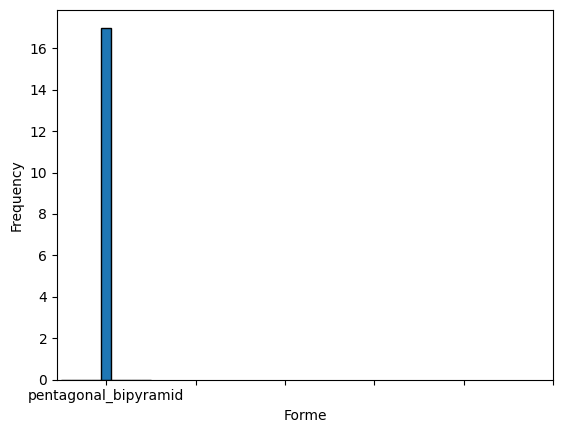

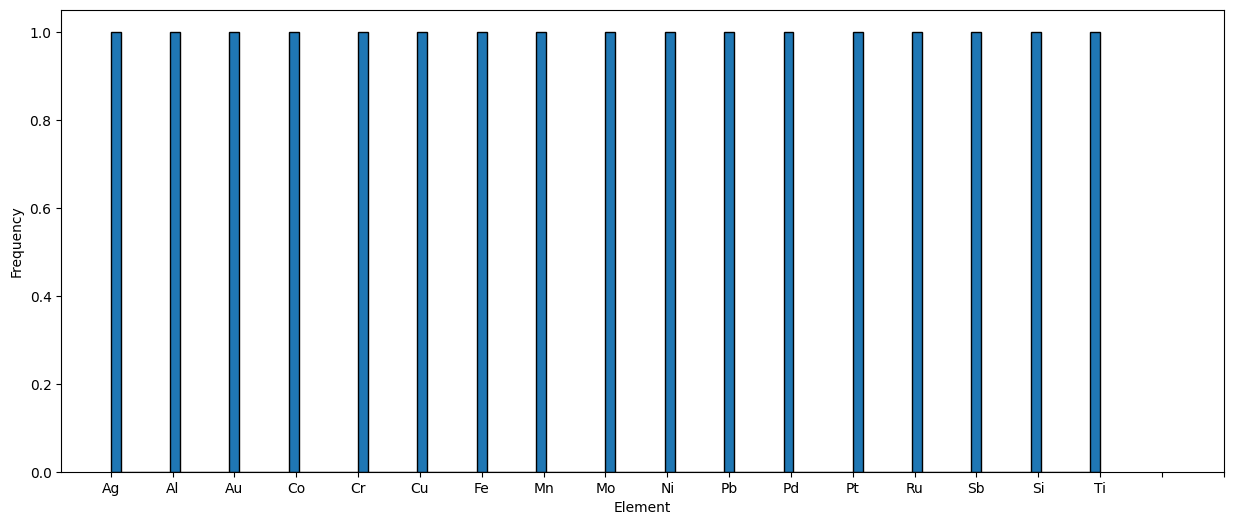

In [34]:

# On va creer un graph qui permet de forme la distribution des formes de notre data frame
import matplotlib.pyplot as plt
# Créer la figure et les axes
fig, ax = plt.subplots()

# Tracer l'histogramme
ax.hist(data['Forme'], bins=9,edgecolor='black')

# Ajouter des labels aux axes
ax.set_xlabel('Forme')
ax.set_ylabel('Frequency')

# Personnaliser les intervalles de l'axe des x
x_ticks = range(0, 6)  # Plage de 0 à 6
plt.xticks(x_ticks)

# Afficher la figure
plt.show()
#--------------------------------------------------------

# On va creer un graph qui permet de forme la distribution des éléments de notre data frame

import matplotlib.pyplot as plt
# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(15,6))


# Tracer l'histogramme
ax.hist(data['Element'], bins=100,edgecolor='black')

# Ajouter des labels aux axes
ax.set_xlabel('Element')
ax.set_ylabel('Frequency')


# Personnaliser les intervalles de l'axe des x
x_ticks = range(0, 19)  # Plage de 0 à 50
plt.xticks(x_ticks)


# Afficher la figure

plt.show()